# Regression with Price only

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from talib.abstract import *
import pandas as pd
import os
import numpy as np

from pythainlp.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn import preprocessing

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from jupyterthemes import jtplot
jtplot.style()

import plotly.graph_objs as go
from datetime import datetime, timedelta
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
% matplotlib inline

target_stocks = ['BANPU','IRPC','PTT','BBL','KBANK','SCB','AOT','THAI','CPF','MINT',
                 'TU','SCC','CPN','CK','CPALL','HMPRO','BDMS','BH','ADVANC','JAS','TRUE']

In [2]:
df_price = pd.read_csv('merged_2014_2017.csv')
df_price['Date'] = pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
df_price = df_price.loc[df_price['Ticker'].isin(target_stocks)]
df_price['Date'] = df_price['Date'].dt.date
df_price = df_price.set_index('Date')
df_price.head(3)
len(df_price)

,Ticker,Open,High,Low,Close,Volume
Date,,,,,,
2014-01-02,ADVANC,198.0,198.50,187.0,187.0,12694200
2014-01-02,AOT,160.5,160.50,146.5,146.5,6963700
2014-01-02,BANPU,30.0,30.25,28.0,28.0,13054500


20494

In [3]:
def lag_construction(data, t_in=3, t_out=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(t_in-1, 0, -1): # input sequence (t-n, ... t-1)
        cols.append(df.shift(i))
        names += [('v%d(t-%d)' % (j+1, i)) for j in range(n_vars)]    
    
    for i in range(0, t_out+1): # forecast sequence (t, t+1, ... t+n)
        cols.append(df.shift(-i))
        if i == 0: names += [('v%d(t)' % (j+1)) for j in range(n_vars)]
        else: names += [('v%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    conbined = pd.concat(cols, axis=1) # put it all together
    conbined.columns = names
    
    conbined.dropna(inplace = True)
    
    return conbined

# Lag & Horizon Construction

In [58]:
df_train = []
df_test = []
for stock in tqdm_notebook(target_stocks):
    news_stocks = []
    df_stock = df_price.loc[df_price['Ticker'] == stock]

    df_stock = lag_construction(df_stock)
    
    
    df_stock = df_stock.drop([ 'v1(t-2)','v6(t-2)',
                               'v1(t-1)','v6(t-1)',
                               'v6(t)',
                               'v1(t+1)','v2(t+1)','v3(t+1)','v4(t+1)','v6(t+1)',
                               ],axis=1)
    
    
    train_size = int(len(df_stock) * 0.80)
    test_size = len(df_stock) - train_size
    train, test = df_stock.iloc[:train_size], df_stock.iloc[train_size:]
    print(stock, ':\t',len(train), len(test))    
    df_train.append(train)
    df_test.append(test)

df_train = pd.concat(df_train, axis=0)
df_test = pd.concat(df_test, axis=0)

len(df_train), len(df_test) 
df_train.head(1)
df_test.head(1)

BANPU :	 778 195
IRPC :	 778 195
PTT :	 778 195
BBL :	 778 195
KBANK :	 778 195
SCB :	 778 195
AOT :	 778 195
THAI :	 778 195
CPF :	 778 195
MINT :	 778 195
TU :	 778 195
SCC :	 778 195
CPN :	 778 195
CK :	 778 195
CPALL :	 778 195
HMPRO :	 778 195
BDMS :	 778 195
BH :	 778 195
ADVANC :	 778 195
JAS :	 776 195
TRUE :	 778 195



(16336, 4095)

,v2(t-2),v3(t-2),v4(t-2),v5(t-2),v2(t-1),v3(t-1),v4(t-1),v5(t-1),v1(t),v2(t),v3(t),v4(t),v5(t),v5(t+1)
Date,,,,,,,,,,,,,,
2014-01-06,30.0,30.25,28.0,28.0,27.5,28.25,26.5,26.5,BANPU,26.0,26.25,24.8,25.25,26.0


,v2(t-2),v3(t-2),v4(t-2),v5(t-2),v2(t-1),v3(t-1),v4(t-1),v5(t-1),v1(t),v2(t),v3(t),v4(t),v5(t),v5(t+1)
Date,,,,,,,,,,,,,,
2017-03-14,19.5,19.6,18.9,19.0,19.0,19.1,18.8,18.8,BANPU,18.8,19.4,18.8,19.2,19.1


# Label Encoding

In [59]:
le = preprocessing.LabelEncoder()

df_train['v1(t)'] = le.fit_transform(df_train['v1(t)'])
df_test['v1(t)'] = le.transform(df_test['v1(t)'])

df_train.head(2)
df_test.head(2)

le.classes_

,v2(t-2),v3(t-2),v4(t-2),v5(t-2),v2(t-1),v3(t-1),v4(t-1),v5(t-1),v1(t),v2(t),v3(t),v4(t),v5(t),v5(t+1)
Date,,,,,,,,,,,,,,
2014-01-06,30.0,30.25,28.0,28.0,27.5,28.25,26.5,26.50,2,26.0,26.25,24.8,25.25,26.0
2014-01-07,27.5,28.25,26.5,26.5,26.0,26.25,24.8,25.25,2,25.0,26.50,25.0,26.00,26.5


,v2(t-2),v3(t-2),v4(t-2),v5(t-2),v2(t-1),v3(t-1),v4(t-1),v5(t-1),v1(t),v2(t),v3(t),v4(t),v5(t),v5(t+1)
Date,,,,,,,,,,,,,,
2017-03-14,19.5,19.6,18.9,19.0,19.0,19.1,18.8,18.8,2,18.8,19.4,18.8,19.2,19.1
2017-03-15,19.0,19.1,18.8,18.8,18.8,19.4,18.8,19.2,2,19.2,19.3,18.9,19.1,19.5


array(['ADVANC', 'AOT', 'BANPU', 'BBL', 'BDMS', 'BH', 'CK', 'CPALL',
       'CPF', 'CPN', 'HMPRO', 'IRPC', 'JAS', 'KBANK', 'MINT', 'PTT',
       'SCB', 'SCC', 'THAI', 'TRUE', 'TU'], dtype=object)

# Create x_train and y_train

In [60]:
y_train = df_train['v5(t+1)']

df_train = df_train.drop('v5(t+1)', axis=1)
x_train = df_train
x_train.shape, y_train.shape

((16336, 13), (16336,))

# Evaluate Each Stcok

In [61]:
def evaluator(clf, df_test, le, isXGB=False):
    RMSEs, MAEs, DAs = [], [], []
    results = []
    for stock in target_stocks:
        x_tmp = df_test.loc[df_test['v1(t)'] == le.transform([stock])[0]].copy()

        y_tmp = x_tmp['v5(t+1)'].values
        
        # Directional Accuracy
        changes = x_tmp['v5(t+1)'] -  x_tmp['v5(t)']
        y_true_da = []
        for change in changes:
            y_true_da.append(1 if change >= 0 else 0)
                
        x_tmp = x_tmp.drop('v5(t+1)', axis=1)
        
        if isXGB:
            y_pred = clf.predict(xgboost.DMatrix(x_tmp))
        else:
            y_pred = clf.predict(x_tmp.as_matrix())
        
        # Directional Accuracy Pred
        changes = y_pred -  x_tmp['v5(t)']
        y_pred_da = []
        for change in changes:
            y_pred_da.append(1 if change >= 0 else 0)
            
        RMSE = np.sqrt(mean_squared_error(y_tmp, y_pred))
        MAE = mean_absolute_error(y_tmp, y_pred)
        DA = accuracy_score(y_true_da, y_pred_da)
        print(stock, "\tRMSE: %.2f\t MAE: %.2f \tDA: %.2f" % (RMSE, MAE, DA))
        RMSEs.append(RMSE)
        MAEs.append(MAE)
        DAs.append(DA)
    
    print('\nmean RMSE:', round(np.mean(RMSEs),2))
    print('mean MAE:', round(np.mean(MAEs),2))
    print('mean DA:', round(np.mean(DAs),4))

# Linear Regression

In [62]:
from sklearn import linear_model

lineregr = linear_model.LinearRegression()
lineregr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [63]:
evaluator(lineregr, df_test, le)

BANPU 	RMSE: 0.26	 MAE: 0.17 	DA: 0.53
IRPC 	RMSE: 0.09	 MAE: 0.07 	DA: 0.66
PTT 	RMSE: 3.52	 MAE: 2.68 	DA: 0.50
BBL 	RMSE: 1.59	 MAE: 1.18 	DA: 0.43
KBANK 	RMSE: 2.28	 MAE: 1.71 	DA: 0.55
SCB 	RMSE: 1.34	 MAE: 1.05 	DA: 0.49
AOT 	RMSE: 0.72	 MAE: 0.53 	DA: 0.45
THAI 	RMSE: 0.42	 MAE: 0.27 	DA: 0.55
CPF 	RMSE: 0.35	 MAE: 0.26 	DA: 0.57
MINT 	RMSE: 0.53	 MAE: 0.40 	DA: 0.63
TU 	RMSE: 0.26	 MAE: 0.18 	DA: 0.57
SCC 	RMSE: 4.33	 MAE: 3.35 	DA: 0.57
CPN 	RMSE: 0.98	 MAE: 0.73 	DA: 0.52
CK 	RMSE: 0.33	 MAE: 0.25 	DA: 0.58
CPALL 	RMSE: 0.61	 MAE: 0.42 	DA: 0.46
HMPRO 	RMSE: 0.18	 MAE: 0.12 	DA: 0.63
BDMS 	RMSE: 0.24	 MAE: 0.17 	DA: 0.52
BH 	RMSE: 2.77	 MAE: 1.92 	DA: 0.50
ADVANC 	RMSE: 1.86	 MAE: 1.39 	DA: 0.46
JAS 	RMSE: 0.12	 MAE: 0.09 	DA: 0.59
TRUE 	RMSE: 0.12	 MAE: 0.09 	DA: 0.62

mean RMSE: 1.09
mean MAE: 0.81
mean DA: 0.5429


# Support Vector Regressor

In [71]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(x_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [72]:
evaluator(svr, df_test, le)

BANPU 	RMSE: 20.58	 MAE: 20.54 	DA: 0.62
IRPC 	RMSE: 32.57	 MAE: 32.56 	DA: 0.66
PTT 	RMSE: 362.66	 MAE: 362.20 	DA: 0.41
BBL 	RMSE: 148.81	 MAE: 148.61 	DA: 0.37
KBANK 	RMSE: 165.62	 MAE: 164.99 	DA: 0.38
SCB 	RMSE: 114.31	 MAE: 114.20 	DA: 0.42
AOT 	RMSE: 15.40	 MAE: 13.01 	DA: 0.32
THAI 	RMSE: 20.01	 MAE: 19.98 	DA: 0.54
CPF 	RMSE: 12.54	 MAE: 12.48 	DA: 0.58
MINT 	RMSE: 3.01	 MAE: 2.53 	DA: 0.46
TU 	RMSE: 18.31	 MAE: 18.28 	DA: 0.57
SCC 	RMSE: 467.40	 MAE: 466.97 	DA: 0.47
CPN 	RMSE: 33.51	 MAE: 32.43 	DA: 0.42
CK 	RMSE: 10.83	 MAE: 10.79 	DA: 0.62
CPALL 	RMSE: 27.40	 MAE: 26.87 	DA: 0.29
HMPRO 	RMSE: 27.62	 MAE: 27.58 	DA: 0.64
BDMS 	RMSE: 18.03	 MAE: 18.00 	DA: 0.57
BH 	RMSE: 155.00	 MAE: 154.04 	DA: 0.43
ADVANC 	RMSE: 144.36	 MAE: 144.19 	DA: 0.38
JAS 	RMSE: 30.36	 MAE: 30.35 	DA: 0.59
TRUE 	RMSE: 32.26	 MAE: 32.26 	DA: 0.62

mean RMSE: 88.6
mean MAE: 88.23
mean DA: 0.4927


# Decistion Tree Regressor

In [46]:
from sklearn import tree
decis_tree_regr = tree.DecisionTreeRegressor()
decis_tree_regr.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [47]:
evaluator(decis_tree_regr, df_test, le)

BANPU 	RMSE: 0.55	 MAE: 0.39 	DA: 0.56
IRPC 	RMSE: 0.19	 MAE: 0.14 	DA: 0.48
PTT 	RMSE: 27.80	 MAE: 7.84 	DA: 0.52
BBL 	RMSE: 2.99	 MAE: 2.34 	DA: 0.51
KBANK 	RMSE: 4.24	 MAE: 3.29 	DA: 0.50
SCB 	RMSE: 2.81	 MAE: 2.10 	DA: 0.52
AOT 	RMSE: 1.79	 MAE: 1.20 	DA: 0.47
THAI 	RMSE: 0.67	 MAE: 0.46 	DA: 0.43
CPF 	RMSE: 0.64	 MAE: 0.46 	DA: 0.57
MINT 	RMSE: 0.88	 MAE: 0.69 	DA: 0.49
TU 	RMSE: 0.44	 MAE: 0.34 	DA: 0.52
SCC 	RMSE: 11.24	 MAE: 8.02 	DA: 0.51
CPN 	RMSE: 1.46	 MAE: 1.11 	DA: 0.53
CK 	RMSE: 0.62	 MAE: 0.48 	DA: 0.49
CPALL 	RMSE: 1.46	 MAE: 1.06 	DA: 0.54
HMPRO 	RMSE: 0.29	 MAE: 0.21 	DA: 0.57
BDMS 	RMSE: 0.43	 MAE: 0.33 	DA: 0.51
BH 	RMSE: 5.19	 MAE: 3.78 	DA: 0.50
ADVANC 	RMSE: 7.03	 MAE: 4.67 	DA: 0.51
JAS 	RMSE: 0.22	 MAE: 0.14 	DA: 0.54
TRUE 	RMSE: 0.21	 MAE: 0.14 	DA: 0.50

mean RMSE: 3.39
mean MAE: 1.87
mean DA: 0.5126


# Random Forest Regrssor

In [70]:
from sklearn import ensemble

rnd_forest_regr = ensemble.RandomForestRegressor(n_jobs=-1)
rnd_forest_regr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [71]:
evaluator(rnd_forest_regr, df_test, le)

BANPU 	RMSE: 0.38	 MAE: 0.29 	DA: 0.56
IRPC 	RMSE: 0.12	 MAE: 0.09 	DA: 0.46
PTT 	RMSE: 28.78	 MAE: 13.20 	DA: 0.48
BBL 	RMSE: 2.02	 MAE: 1.53 	DA: 0.50
KBANK 	RMSE: 2.69	 MAE: 2.04 	DA: 0.54
SCB 	RMSE: 1.60	 MAE: 1.24 	DA: 0.53
AOT 	RMSE: 0.87	 MAE: 0.63 	DA: 0.52
THAI 	RMSE: 0.50	 MAE: 0.32 	DA: 0.49
CPF 	RMSE: 0.40	 MAE: 0.30 	DA: 0.54
MINT 	RMSE: 0.62	 MAE: 0.47 	DA: 0.48
TU 	RMSE: 0.31	 MAE: 0.23 	DA: 0.49
SCC 	RMSE: 5.19	 MAE: 4.03 	DA: 0.52
CPN 	RMSE: 1.48	 MAE: 1.10 	DA: 0.55
CK 	RMSE: 0.39	 MAE: 0.30 	DA: 0.53
CPALL 	RMSE: 1.02	 MAE: 0.75 	DA: 0.50
HMPRO 	RMSE: 0.20	 MAE: 0.15 	DA: 0.60
BDMS 	RMSE: 0.28	 MAE: 0.21 	DA: 0.57
BH 	RMSE: 3.16	 MAE: 2.32 	DA: 0.44
ADVANC 	RMSE: 3.26	 MAE: 2.41 	DA: 0.50
JAS 	RMSE: 0.15	 MAE: 0.12 	DA: 0.44
TRUE 	RMSE: 0.12	 MAE: 0.10 	DA: 0.45

mean RMSE: 2.55
mean MAE: 1.52
mean DA: 0.5092


# AdaBoost Regressor

In [15]:
adaboost_dt_regr = ensemble.AdaBoostRegressor(base_estimator=tree.DecisionTreeRegressor(),
                                           learning_rate=1, 
                                           n_estimators=50, 
                                           loss='linear')
adaboost_dt_regr.fit(x_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1, loss='linear', n_estimators=50,
         random_state=None)

In [76]:
adaboost_rf_regr = ensemble.AdaBoostRegressor(base_estimator=ensemble.RandomForestRegressor(n_jobs=-1),
                                           learning_rate=1, 
                                           n_estimators=50, 
                                           loss='linear')
adaboost_rf_regr.fit(x_train, y_train)

AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
         learning_rate=1, loss='linear', n_estimators=50,
         random_state=None)

In [17]:
evaluator(adaboost_dt_regr, df_test, le)


mean RMSE: 1.42
mean MAE: 1.06
mean DA: 0.5531


In [77]:
evaluator(adaboost_rf_regr, df_test, le)

BANPU 	RMSE: 0.33	 MAE: 0.26 	DA: 0.55
IRPC 	RMSE: 0.10	 MAE: 0.08 	DA: 0.40
PTT 	RMSE: 23.78	 MAE: 6.42 	DA: 0.54
BBL 	RMSE: 1.80	 MAE: 1.31 	DA: 0.53
KBANK 	RMSE: 2.52	 MAE: 1.94 	DA: 0.53
SCB 	RMSE: 1.49	 MAE: 1.15 	DA: 0.54
AOT 	RMSE: 0.80	 MAE: 0.57 	DA: 0.59
THAI 	RMSE: 0.47	 MAE: 0.31 	DA: 0.57
CPF 	RMSE: 0.36	 MAE: 0.28 	DA: 0.57
MINT 	RMSE: 0.57	 MAE: 0.46 	DA: 0.46
TU 	RMSE: 0.28	 MAE: 0.20 	DA: 0.52
SCC 	RMSE: 5.78	 MAE: 4.34 	DA: 0.56
CPN 	RMSE: 1.37	 MAE: 1.03 	DA: 0.51
CK 	RMSE: 0.34	 MAE: 0.27 	DA: 0.55
CPALL 	RMSE: 1.04	 MAE: 0.72 	DA: 0.51
HMPRO 	RMSE: 0.19	 MAE: 0.13 	DA: 0.57
BDMS 	RMSE: 0.27	 MAE: 0.19 	DA: 0.58
BH 	RMSE: 3.07	 MAE: 2.14 	DA: 0.47
ADVANC 	RMSE: 2.85	 MAE: 2.14 	DA: 0.48
JAS 	RMSE: 0.13	 MAE: 0.09 	DA: 0.49
TRUE 	RMSE: 0.11	 MAE: 0.08 	DA: 0.53

mean RMSE: 2.27
mean MAE: 1.15
mean DA: 0.5272


# Gradient Boosting Regressor

In [74]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=100, 
                                         learning_rate=0.1,
                                         max_depth=6,
                                         min_samples_split=2,
                                         loss='ls'
                                        )
gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [75]:
evaluator(gbr, df_test, le)

BANPU 	RMSE: 0.30	 MAE: 0.23 	DA: 0.57
IRPC 	RMSE: 0.11	 MAE: 0.09 	DA: 0.57
PTT 	RMSE: 14.98	 MAE: 6.43 	DA: 0.50
BBL 	RMSE: 1.63	 MAE: 1.22 	DA: 0.53
KBANK 	RMSE: 2.42	 MAE: 1.80 	DA: 0.48
SCB 	RMSE: 1.43	 MAE: 1.13 	DA: 0.51
AOT 	RMSE: 0.80	 MAE: 0.57 	DA: 0.64
THAI 	RMSE: 0.44	 MAE: 0.28 	DA: 0.56
CPF 	RMSE: 0.36	 MAE: 0.27 	DA: 0.60
MINT 	RMSE: 0.57	 MAE: 0.45 	DA: 0.47
TU 	RMSE: 0.28	 MAE: 0.20 	DA: 0.55
SCC 	RMSE: 5.30	 MAE: 4.06 	DA: 0.51
CPN 	RMSE: 1.38	 MAE: 1.06 	DA: 0.51
CK 	RMSE: 0.33	 MAE: 0.26 	DA: 0.55
CPALL 	RMSE: 1.18	 MAE: 0.86 	DA: 0.37
HMPRO 	RMSE: 0.21	 MAE: 0.14 	DA: 0.49
BDMS 	RMSE: 0.25	 MAE: 0.19 	DA: 0.55
BH 	RMSE: 2.79	 MAE: 1.94 	DA: 0.52
ADVANC 	RMSE: 1.96	 MAE: 1.50 	DA: 0.44
JAS 	RMSE: 0.13	 MAE: 0.10 	DA: 0.51
TRUE 	RMSE: 0.13	 MAE: 0.11 	DA: 0.50

mean RMSE: 1.76
mean MAE: 1.09
mean DA: 0.5206


# XGBoost Regressor

In [65]:
import xgboost
from sklearn.model_selection import train_test_split

In [66]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=10)
len(x_train), len(x_valid)

(13068, 3268)

In [67]:
d_train = xgboost.DMatrix(x_train, label=y_train)
d_valid = xgboost.DMatrix(x_valid, label=y_valid)

In [68]:
params = {
    'booster':'gbtree',
    'max_depth': 6,
    'learning_rate': 0.01,
    'n_estimators':100,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'reg_lambda': 0.8,   
    'reg_alpha': 0.4, 
    'silent': 1,
}

xgb = xgboost.train(params, d_train, 
                    num_boost_round=5000, 
                    evals=[(d_train, 'train'), (d_valid, 'valid')], 
                    early_stopping_rounds=30,
                    verbose_eval=10
                   )

[0]	train-rmse:167.869	valid-rmse:164.729
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[10]	train-rmse:151.894	valid-rmse:149.027
[20]	train-rmse:137.436	valid-rmse:134.83
[30]	train-rmse:124.361	valid-rmse:121.991
[40]	train-rmse:112.535	valid-rmse:110.373
[50]	train-rmse:101.831	valid-rmse:99.863
[60]	train-rmse:92.1506	valid-rmse:90.3543
[70]	train-rmse:83.3909	valid-rmse:81.7493
[80]	train-rmse:75.4708	valid-rmse:73.9703
[90]	train-rmse:68.3041	valid-rmse:66.9311
[100]	train-rmse:61.8184	valid-rmse:60.563
[110]	train-rmse:55.9503	valid-rmse:54.8034
[120]	train-rmse:50.6469	valid-rmse:49.5946
[130]	train-rmse:45.8461	valid-rmse:44.8797
[140]	train-rmse:41.507	valid-rmse:40.6213
[150]	train-rmse:37.5807	valid-rmse:36.7659
[160]	train-rmse:34.0331	valid-rmse:33.2822
[170]	train-rmse:30.826	valid-rmse:30.1395
[180]	train-rmse:27.9238	valid-rmse:27.2945
[190]	train-rmse:25.3003	valid-rmse

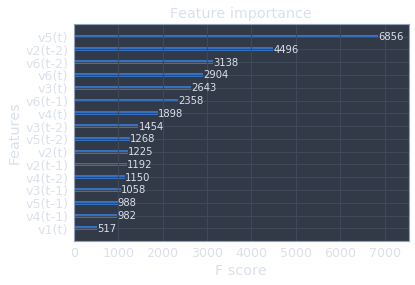

In [64]:
xgboost.plot_importance(xgb, height=0.3)

In [56]:
evaluator(xgb, df_test, le, isXGB=True)

BANPU 	RMSE: 0.29	 MAE: 0.21 	DA: 0.59
IRPC 	RMSE: 0.10	 MAE: 0.08 	DA: 0.66
PTT 	RMSE: 30.26	 MAE: 16.08 	DA: 0.52
BBL 	RMSE: 1.64	 MAE: 1.21 	DA: 0.57
KBANK 	RMSE: 2.43	 MAE: 1.83 	DA: 0.51
SCB 	RMSE: 1.49	 MAE: 1.16 	DA: 0.46
AOT 	RMSE: 0.80	 MAE: 0.59 	DA: 0.61
THAI 	RMSE: 0.43	 MAE: 0.27 	DA: 0.56
CPF 	RMSE: 0.37	 MAE: 0.29 	DA: 0.60
MINT 	RMSE: 0.59	 MAE: 0.47 	DA: 0.49
TU 	RMSE: 0.27	 MAE: 0.20 	DA: 0.57
SCC 	RMSE: 5.86	 MAE: 4.66 	DA: 0.54
CPN 	RMSE: 1.38	 MAE: 1.04 	DA: 0.48
CK 	RMSE: 0.34	 MAE: 0.27 	DA: 0.56
CPALL 	RMSE: 1.18	 MAE: 0.85 	DA: 0.39
HMPRO 	RMSE: 0.20	 MAE: 0.14 	DA: 0.58
BDMS 	RMSE: 0.26	 MAE: 0.19 	DA: 0.53
BH 	RMSE: 2.84	 MAE: 2.05 	DA: 0.47
ADVANC 	RMSE: 1.96	 MAE: 1.50 	DA: 0.50
JAS 	RMSE: 0.13	 MAE: 0.10 	DA: 0.55
TRUE 	RMSE: 0.12	 MAE: 0.09 	DA: 0.62

mean RMSE: 2.52
mean MAE: 1.59
mean DA: 0.5411
